#  Convolutional Neural Network | Dogs vs. Cats

*CS 334 - Algorithms of Machine Learning | Conrad Kennington*

*Computer Science | Boise State University*

*12.05.2022 | Fall 2022*

*Aida Gomezbueno Berezo | aidagomezbuenobe@u.boisestate.edu*

#### Importing libraries + files from fastai

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.data.external import *
from fastai.data.transforms import *
from fastai.metrics import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.vision.data import *
import numpy as np
import os
import os.path
import ssl
import stat
import subprocess
import sys

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [8]:
STAT_0o775 = ( stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR
             | stat.S_IRGRP | stat.S_IWGRP | stat.S_IXGRP
             | stat.S_IROTH |                stat.S_IXOTH )

openssl_dir, openssl_cafile = os.path.split(ssl.get_default_verify_paths().openssl_cafile)
print(" -- pip install --upgrade certifi")
subprocess.check_call([sys.executable, "-E", "-s", "-m", "pip", "install", "--upgrade", "certifi"])
import certifi
os.chdir(openssl_dir)
relpath_to_certifi_cafile = os.path.relpath(certifi.where())
print(" -- removing any existing file or link")
try:
    os.remove(openssl_cafile)
except FileNotFoundError:
    pass
print(" -- creating symlink to certifi certificate bundle")
os.symlink(relpath_to_certifi_cafile, openssl_cafile)
print(" -- setting permissions")
os.chmod(openssl_cafile, STAT_0o775)
print(" -- update complete")

 -- pip install --upgrade certifi
 -- removing any existing file or link
 -- creating symlink to certifi certificate bundle
 -- setting permissions
 -- update complete


In [9]:
path = untar_data(URLs.DOGS); path

Path('/Users/aidagomezbuenoberezo/.fastai/data/dogscats')

In [10]:
path.ls()

(#5) [Path('/Users/aidagomezbuenoberezo/.fastai/data/dogscats/valid'),Path('/Users/aidagomezbuenoberezo/.fastai/data/dogscats/test1'),Path('/Users/aidagomezbuenoberezo/.fastai/data/dogscats/models'),Path('/Users/aidagomezbuenoberezo/.fastai/data/dogscats/sample'),Path('/Users/aidagomezbuenoberezo/.fastai/data/dogscats/train')]

In [11]:
batch_size=64

In [12]:
dog_files = get_image_files(path/"train/dogs")
ndf = len(dog_files)
cat_files = get_image_files(path/"train/cats")
for i in cat_files:
    dog_files.append(i)
files = dog_files

In [13]:
print("Dog files:", ndf, "\nCat files:", len(cat_files))
print("\tTotal files: ", len(files))

Dog files: 11500 
Cat files: 11500
	Total files:  23000


#### Selecting criteria | Image formatting

In [14]:
pat=r'(\w+).*\d+.jpg'

In [15]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(500), batch_tfms=aug_transforms(size=224), num_workers=0)

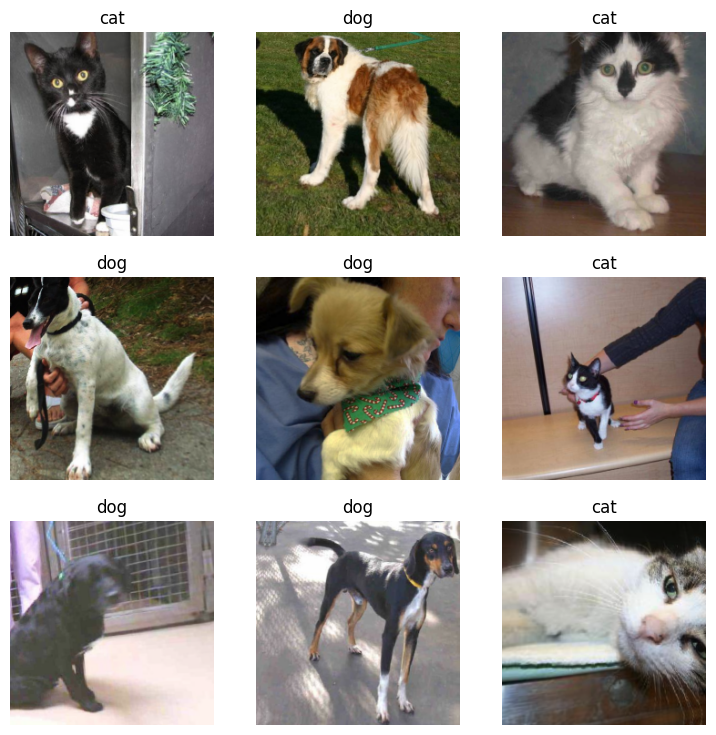

In [15]:
dls.show_batch()

#### Training model

In [16]:
learn = vision_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(), metrics=error_rate)

SuggestedLRs(valley=0.0005754399462603033)

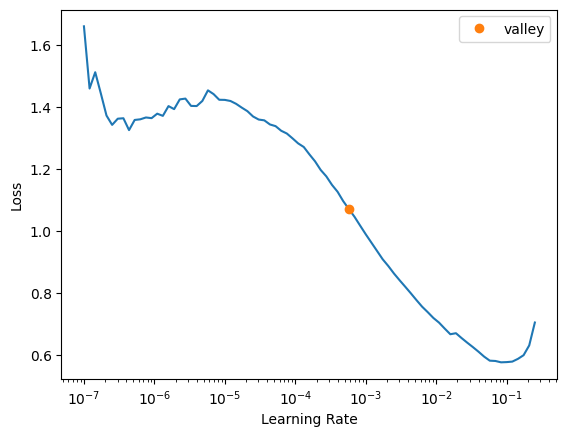

In [17]:
learn.lr_find()

#### Fine tuning | Improving performance + accuracy

In [18]:
learn.fine_tune(4, 3e-3)

#### Prediction results

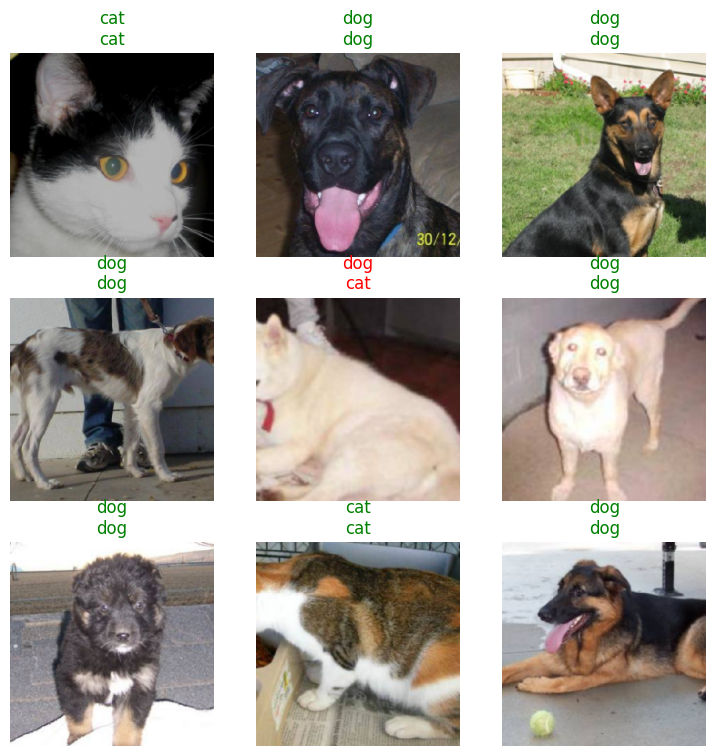

In [19]:
learn.show_results()

In [20]:
interp = Interpretation.from_learner(learn)

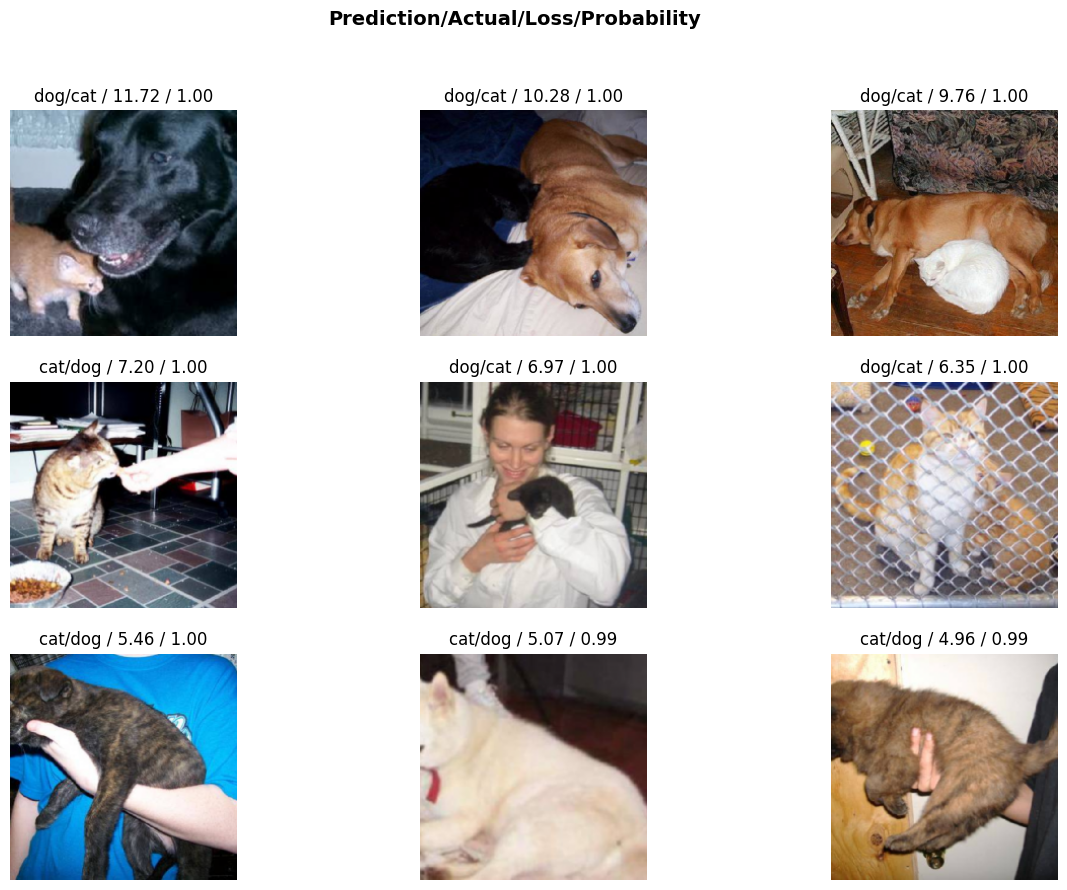

In [23]:
interp.plot_top_losses(9, figsize=(15, 10))

In [24]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [26]:
learn.fit_one_cycle(4)

In [27]:
learn.save('stage-1')

Path('/Users/aidagomezbuenoberezo/.fastai/data/dogscats/models/stage-1.pth')

In [28]:
interp=ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

True

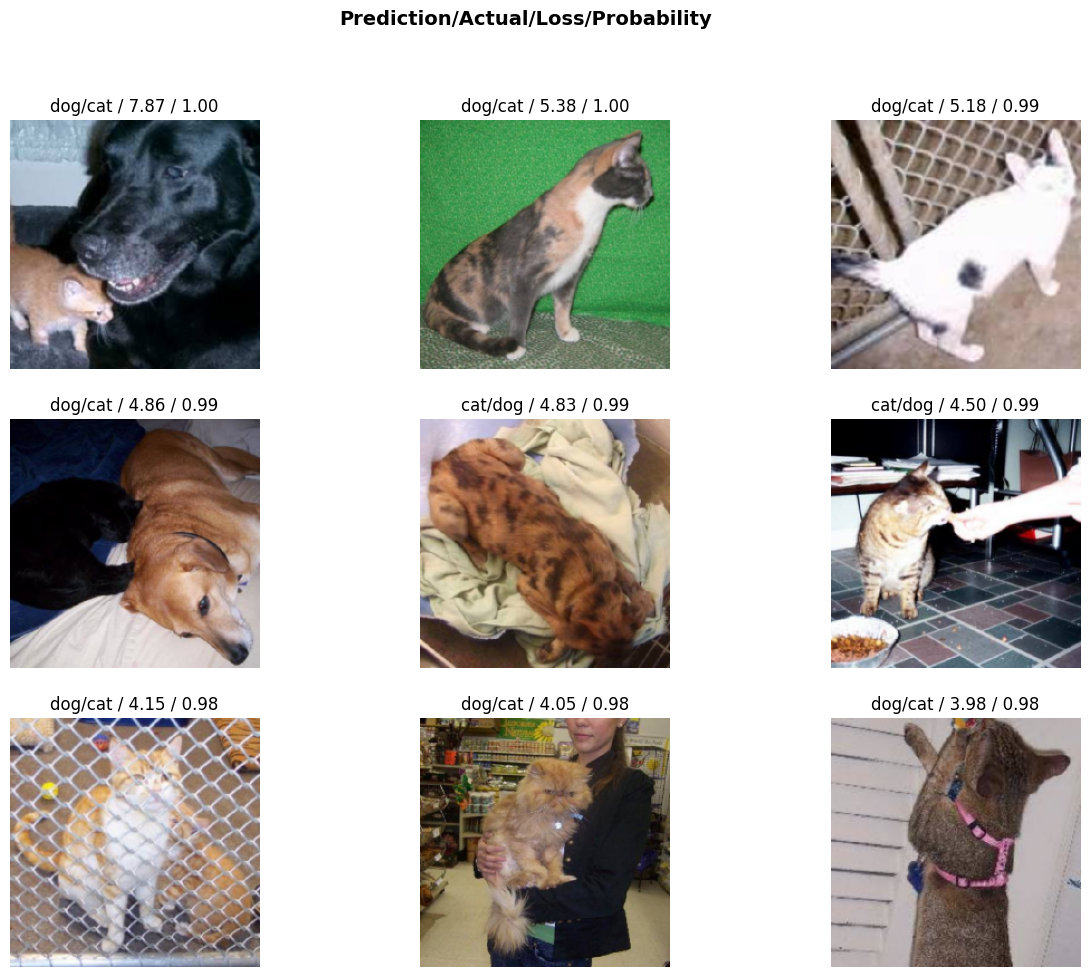

In [29]:
interp.plot_top_losses(9, figsize=(15, 11))

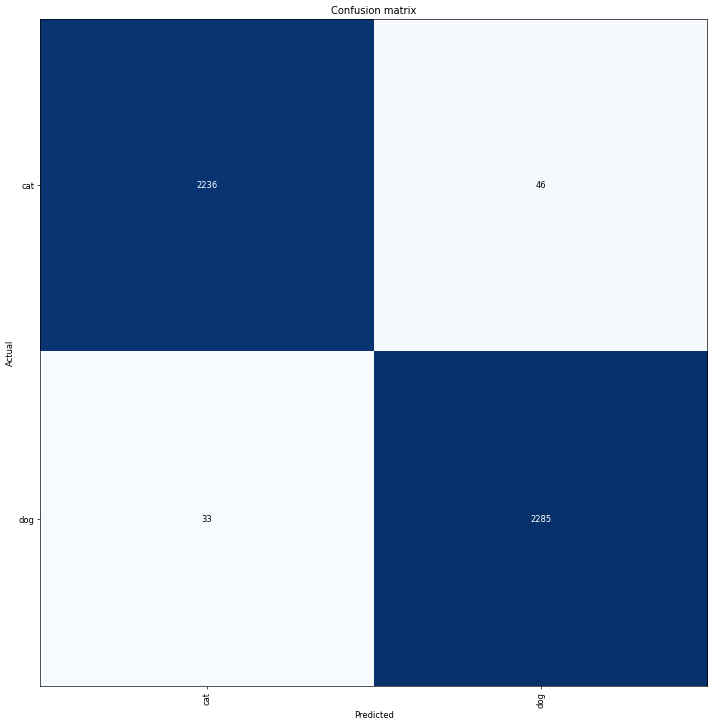

In [30]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [31]:
interp.most_confused(min_val=2)

[('cat', 'dog', 46), ('dog', 'cat', 33)]